# DA序列控制基本功能测试

In [1]:
from datetime import time
from DAboard import *
from IPython.display import Image
import matplotlib.pyplot as plt
import logging

In [2]:
#setup
logger = logging.getLogger()
logger.setLevel(logging.INFO)

## 测试连接示意图

单DA板测试，主要测试序列控制功能

DA到AD的触发输出连接到示波器1通道，波形输出连接到3通道

DA与示波器均要与上位机连接到同一个网络

## 准备序列
### 一级触发输出开始单元

In [3]:
addr = 0
length = 4
ctrl = 0x1 << 11
loop_cnt = 2
loop_level = 0
ctrl = ctrl | (loop_level << 8)
seq_L1 =  [addr,4,loop_cnt,ctrl]
seq_L1

[0, 4, 2, 2048]

### 一级触发输出停止单元

In [4]:
ctrl = 0x2 << 11
jump_addr = 1
loop_level = 0
ctrl = ctrl | (loop_level << 8)
seq_J1 =  [addr,4,jump_addr,ctrl]
seq_J1

[0, 4, 1, 4096]

### 二级触发输出开始单元

In [5]:
ctrl = 0x1 << 11
loop_cnt = 3
loop_level = 1
ctrl = ctrl | (loop_level << 8)
seq_L2 =  [addr,4,loop_cnt,ctrl]
seq_L2

[0, 4, 3, 2304]

### 二级触发输出停止单元

In [6]:
ctrl = 0x2 << 11
jump_addr = 2
loop_level = 1
ctrl = ctrl | (loop_level << 8)
seq_J2 =  [addr,4,jump_addr,ctrl]
seq_J2

[0, 4, 2, 4352]

### 三级触发输出开始单元

In [7]:
ctrl = 0x1 << 11
loop_cnt = 2
loop_level = 2
ctrl = ctrl | (loop_level << 8)
seq_L3 =  [addr,4,loop_cnt,ctrl]
seq_L3

[0, 4, 2, 2560]

### 三级触发输出停止单元

In [8]:
ctrl = 0x2 << 11
jump_addr = 3
loop_level = 2
ctrl = ctrl | (loop_level << 8)
seq_J3 =  [addr,4,jump_addr,ctrl]
seq_J3

[0, 4, 3, 4608]

### 四级触发输出开始单元

In [9]:
ctrl = 0x1 << 11
loop_cnt = 3
loop_level = 3
ctrl = ctrl | (loop_level << 8)
seq_L4 =  [addr,4,loop_cnt,ctrl]
seq_L4

[0, 4, 3, 2816]

### 四级触发输出停止单元

In [10]:
ctrl = 0x2 << 11
jump_addr = 8
loop_level = 3
ctrl = ctrl | (loop_level << 8)
seq_J4 =  [addr,4,jump_addr,ctrl]
seq_J4

[0, 4, 8, 4864]

### 触发单元 正弦 周期为16个采样点

In [11]:
#触发类型，地址为0，长度为64ns ， 重复次数为0
ctrl = 0x8 << 11
start_addr = 0
length = 16
seq_T =  [start_addr,length,0,ctrl]
seq_T

[0, 16, 0, 16384]

### 计时输出单元  正弦波（周期为128个采样点）

In [12]:
#计时输出类型，地址为16，长度为128ns 计时2ns
ctrl = 0x4 << 11
start_addr = 16
length = 32
seq_D =  [start_addr,length,2,ctrl]
seq_D

[16, 32, 2, 8192]

### 态判断输出单元

In [13]:
ctrl = 0xC << 11
start_addr1 = 1#1态
start_addr2 = 1#2态
start_addr3 = 1#NULL态
start_addr4 = 1#0态
seq_C =  [start_addr1<<8 | start_addr2,64,start_addr3<<8 | start_addr4,ctrl]
seq_C

[257, 64, 257, 24576]

### 停止序列

In [14]:
seq_T_stop=[0,16,0,seq_D[3]|(1<<15)]

## 准备波形
### 波形区说明
0-15地址为16x4=64ns的正弦波（周期为16个采样点）    触发  
16-47地址为32x4=128ns的正弦波（周期为256个采样点） 计数  
48-127地址为80x4=320ns的方波（周期为640个采样点）  
触发序列收到触发时输出0-31的波形：seq_T=[0, 16, 0, 16384]  
计数序列输出32-63地址的正弦波： seq_D=[16, 32, 2, 8192]  
态判断输出0态时输出64-95地址的波形，1态时输出64-95地址的波形。seq_C=[258, 64, 769, 24576]


In [15]:
da_ctrl = waveform()
da_ctrl.generate_sin(repeat=10,cycle_count=16)
# da_ctrl.generate_seq(length=len(da_ctrl.wave)>>4)
# da_ctrl.gen_comp_wave()
# count_seq = [0, 64, 2, 4<<11]*2
tmp_wave = da_ctrl.wave[0:128]
da_ctrl.generate_sin(repeat=3,cycle_count=256)
tmp_wave += da_ctrl.wave[0:256]
# da_ctrl.generate_cos(repeat=3,cycle_count=256)
da_ctrl.generate_squr(repeat=4, hightime=320,lowtime1=160,lowtime2=160)
tmp_wave += da_ctrl.wave[0:640]
da_ctrl.wave = tmp_wave

### 基础波形

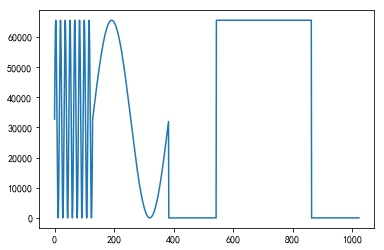

In [16]:
plt.figure()
plt.plot(da_ctrl.wave)
plt.show()

## 准备DA

In [17]:
from DAboard import *
da = DABoard()
ip = '10.0.5.5'

Calling Board_Defines class constructor


In [18]:
da.connect(ip)
da.InitBoard()
da.SetLoop(1,1,1,1)
da.SetDefaultVolt(1,32768)
da.SetDefaultVolt(2,32768)
da.SetDefaultVolt(3,32768)
da.SetDefaultVolt(4,32768)
da.StartStop(240) #停止所有输出
for i in range(1,5): #4个通道均写入基础波形
    da.WriteWave(i,da_ctrl.wave)

Host name is: 10.0.5.5
connected


### DA逻辑版本

In [19]:
print(da.soft_version)

[1, 66, 28]


## 准备触发

In [20]:
da.MultiBoardMode(1) #1是单板工作
da.SetTrigCount(1)
da.SetTrigCountL2(1)
da.SetTrigInterval(200*250)#200us触发间隔
da.SetTrigIntervalL2(200*250)#200us触发间隔
da.SetTrigStart(52) 
da.SetDACStart(1)
da.SwitchTrigMode(1)

## 准备示波器

In [21]:
## %matplotlib notebook
import matplotlib.pyplot as plt
import qcodes as qc
from qcodes.instrument_drivers.rohde_schwarz.RTO1000 import RTO1000

### 示波器地址 

In [22]:
rto = RTO1000('rto', 'TCPIP0::10.0.0.230::inst0::INSTR')

Connected to: Rohde&Schwarz RTO (serial:1329.7002k14/300087, firmware:3.65.1.0) in 0.25s


复位示波器，进入初始设置

In [23]:
rto.reset()
rto.display('view')

### 使能连接信号的通道  

In [24]:
rto.ch3.coupling('DC')  # 'DC' means DC 50 Ohm, 'DCLimit' means DC 1 MOhm, 'AC' means AC 1 MOhm.
rto.ch3.state('ON')
# This is EXACTLY matching the waveform...
rto.ch3.range(2)
rto.ch3.offset(0.3)

In [25]:
rto.ch1.coupling('DC')  # 'DC' means DC 50 Ohm, 'DCLimit' means DC 1 MOhm, 'AC' means AC 1 MOhm.
rto.ch1.state('ON')
# This is EXACTLY matching the waveform...
ch1_range = 2
rto.ch1.range(ch1_range)
rto.ch1.offset(-0.3)

### 设置示波器显示  
设置通道在屏幕的偏移位置  
设置时间尺度  
设置电压尺度  

In [26]:
rto.timebase_range(1/100e3)
rto.timebase_position(5e-6)

### 设置示波器触发   
设置触发通道  
设置触发电平  
设置触发显示位置  
示波器进入等待触发状态   

In [27]:
rto.trigger_source('CH1')
rto.trigger_type('EDGE')
rto.trigger_edge_slope('POS')
rto.trigger_level(0.5)
rto.trigger_mode('NORM')

## 波形输出与读回对比测试

### DA发出的波形数据与示波器采集回的数据进行归一化的叠加显示函数

In [28]:
import numpy as np

def process_waves(wave, osc_data):
    wave_data = np.asarray(wave)
    print()
#     wave_data = wave_data[0:-1]
    space = wave_data.max()-wave_data.min()
    min_val = wave_data.min()
    wave_data = (wave_data-min_val)/space
    length = len(wave)
    
    osc_data = osc_data[::5,]
    osc_data = osc_data[18:18+length-1,]

    space = osc_data.max()-osc_data.min()
    min_val = osc_data.min()
    osc_data = (osc_data-min_val)/space
    # da.disconnect()
    plot = qc.MatPlot(subplots=1,figsize=(10,3))
    plot[0].add(wave_data,xlabel="采样点", xunit="(5e-10)",\
                ylabel= "归一化显示电压值",yunit ="V")
    plot[0].add(osc_data,xlabel="采样点", xunit="(5e-10)",\
                ylabel= "归一化显示电压值",yunit ="V")

In [29]:
def send_and_read_back_wave(sample_count, rto, da, da_ctrl, trig_time):
#     duration = (int(sample_count+40) >> 1) * 10e-10
    duration = int((sample_count+199)/200) * 10e-8
    rto.timebase_range(duration) 
    rto.timebase_position(duration/2 - 10e-9)

#     rto.run_cont()
    rto.run_single()  # and perform a single run. 
    time.sleep(0.2)
    print(da_ctrl.seq)
    for i in range(1,5):
        da.WriteSeq(i,da_ctrl.seq)

    da.StartStop(15)

    da.SendIntTrig()

    #读取示波器波形数据并画图

    # Next, the trace must be prepared. This ensures that all settings are correct
    rto.ch3.trace.prepare_trace()
    rto.ch1.trace.prepare_trace()
    # Now make a measurement of the trace and display it
    data_tr3 = qc.Measure(rto.ch3.trace).run()
    data_tr1 = qc.Measure(rto.ch1.trace).run()
    
    osc_data = data_tr1.arrays['trace'][100::5]
    pre_volt = 0.0;
    osc_trig_time = []
    for i in range(len(osc_data)):
        if osc_data[i] > 0.5 and pre_volt <= 0.5:
            osc_trig_time.append(i*0.5)
        pre_volt = osc_data[i]
    for i in range(min(len(trig_time), len(osc_trig_time))):
        if trig_time[i] != osc_trig_time[i]:
            print('触发时刻不匹配：预期{}，实际{}'.format(trig_time[i],osc_trig_time[i]))
        else:
            print('触发时刻匹配:{}'.format(osc_trig_time[i]))
    plot = qc.MatPlot(subplots=1, figsize=(10,4))
    plot[0].add(data_tr1.arrays['trace'])
    plot[0].add(data_tr3.arrays['trace'])
    return data_tr3

### 无嵌套

In [30]:
# da.SendIntTrig()

触发时刻:0.0ns
触发时刻:64.0ns
[0, 104, 208, 312, 416, 520, 624, 728, 832, 936, 1039]


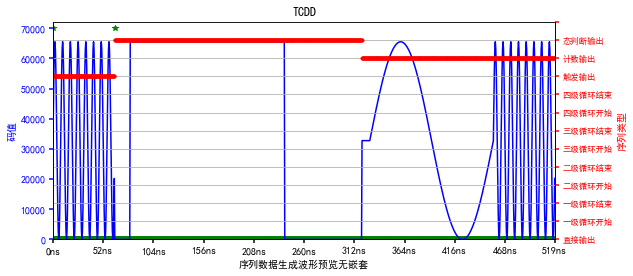

[0, 16, 0, 17453, 257, 64, 257, 25645, 16, 32, 2, 8192, 0, 16, 0, 40960, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [31]:
# %matplotlib notebook
da.SwitchTrigMode(1)
seq_T[3] &= 0xF800
seq_T[3] = seq_T[3] | (1<<10) | 45
seq_T[2] = 0
seq_C[3] &= 0xF800
seq_C[3] = seq_C[3] | (1<<10) | 45
da_ctrl.seq = seq_T+seq_C+seq_D+seq_T_stop+[0,0,0,0]*10
sample_count,wave,trig_time = da_ctrl.wave_preview('无嵌套')
print(da_ctrl.seq)

#### 发送波形并读取示波器波形数据并画图

[0, 16, 0, 17453, 257, 64, 257, 25645, 16, 32, 2, 8192, 0, 16, 0, 40960, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
DataSet:
   location = 'data/2018-09-21/#260_{name}_20-17-15'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Measured | trace      | trace        | (6000,)
acquired at 2018-09-21 20:17:15
DataSet:
   location = 'data/2018-09-21/#261_{name}_20-17-15'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Measured | trace      | trace        | (6000,)
acquired at 2018-09-21 20:17:15
触发时刻匹配:0.0
触发时刻匹配:64.0


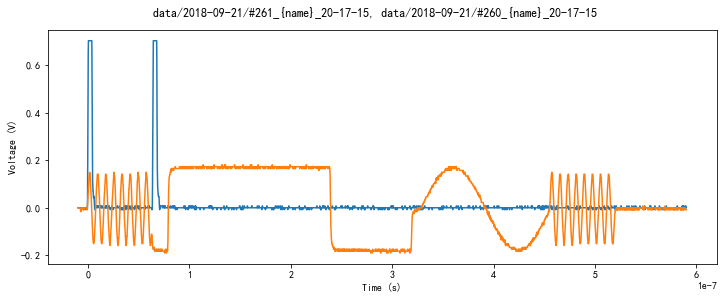

In [32]:
data_tr3 = send_and_read_back_wave(sample_count, rto, da, da_ctrl, trig_time)

#### 归一化显示发送波形与示波器采集的波形

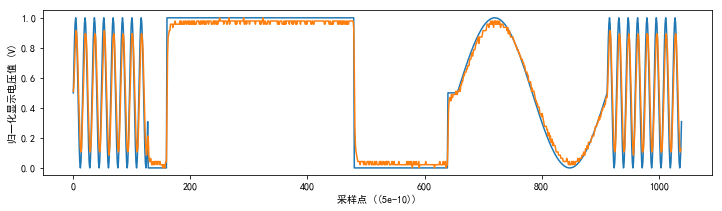

In [33]:
# %matplotlib notebook
process_waves(wave, data_tr3.arrays['trace'])

读取示波器波形数据并画图

### 一层嵌套

触发时刻:0.0ns
触发时刻:216.0ns
触发时刻:640.0ns
0层循环起始：地址：1
0层循环结束：跳转：1
[0, 195, 390, 585, 780, 975, 1170, 1365, 1560, 1755, 1950, 1951]


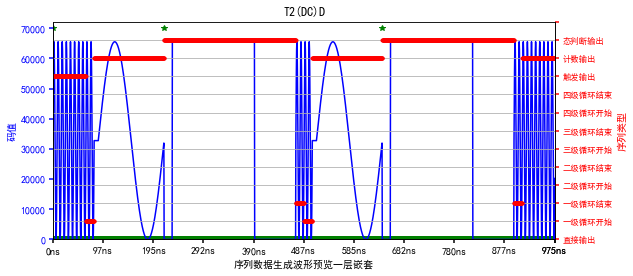

In [34]:
# %matplotlib notebook
da_ctrl.seq = seq_T+seq_L1+seq_D+seq_C+seq_J1+seq_T_stop+[0,0,0,0]*4
sample_count,wave,trig_time = da_ctrl.wave_preview('一层嵌套')

#### 发送波形并读取示波器波形数据并画图

[0, 16, 0, 17453, 0, 4, 2, 2048, 16, 32, 2, 8192, 257, 64, 257, 25645, 0, 4, 1, 4096, 0, 16, 0, 40960, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
DataSet:
   location = 'data/2018-09-21/#262_{name}_20-17-16'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Measured | trace      | trace        | (10000,)
acquired at 2018-09-21 20:17:16
DataSet:
   location = 'data/2018-09-21/#263_{name}_20-17-16'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Measured | trace      | trace        | (10000,)
acquired at 2018-09-21 20:17:16
触发时刻匹配:0.0
触发时刻匹配:216.0
触发时刻匹配:640.0


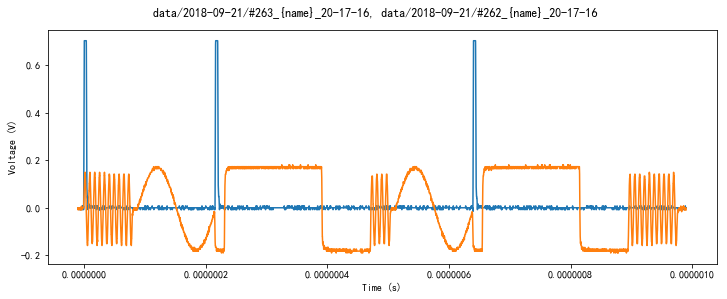

In [35]:
data_tr3 = send_and_read_back_wave(sample_count, rto, da, da_ctrl,trig_time)

#### 归一化显示发送波形与示波器采集的波形

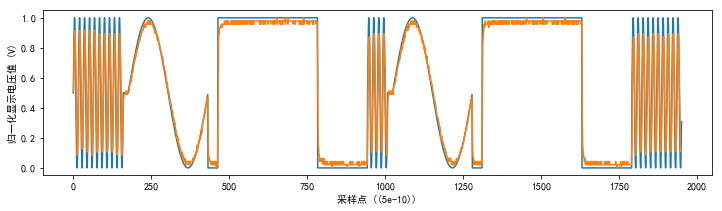

In [36]:
process_waves(wave, data_tr3.arrays['trace'])

### 两层嵌套(Loop指令开始带触发输出)

触发时刻:0.0ns
触发时刻:64.0ns
触发时刻:232.0ns
触发时刻:656.0ns
触发时刻:1080.0ns
触发时刻:1368.0ns
触发时刻:1536.0ns
触发时刻:1960.0ns
触发时刻:2384.0ns
0层循环起始：地址：1
1层循环起始：地址：2
1层循环结束：跳转：2
0层循环结束：跳转：1
[0, 547, 1094, 1641, 2188, 2735, 3282, 3829, 4376, 4923, 5470, 5471]


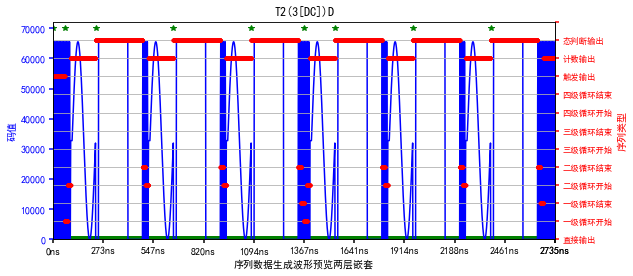

In [37]:
seq_L1[3] &= 0xF800
seq_L1[3] = seq_L1[3] | (1<<10) | 45
da_ctrl.seq = seq_T+seq_L1+seq_L2+seq_D+seq_C+seq_J2+seq_J1+seq_T_stop+[0,0,0,0]*10
sample_count,wave,trig_time = da_ctrl.wave_preview('两层嵌套')

#### 发送波形并读取示波器波形数据并画图

[0, 16, 0, 17453, 0, 4, 2, 3117, 0, 4, 3, 2304, 16, 32, 2, 8192, 257, 64, 257, 25645, 0, 4, 2, 4352, 0, 4, 1, 4096, 0, 16, 0, 40960, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
DataSet:
   location = 'data/2018-09-21/#264_{name}_20-17-17'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Measured | trace      | trace        | (28000,)
acquired at 2018-09-21 20:17:17
DataSet:
   location = 'data/2018-09-21/#265_{name}_20-17-17'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Measured | trace      | trace        | (28000,)
acquired at 2018-09-21 20:17:17
触发时刻匹配:0.0
触发时刻匹配:64.0
触发时刻匹配:232.0
触发时刻匹配:656.0
触发时刻匹配:1080.0
触发时刻匹配:1368.0
触发时刻匹配:1536.0
触发时刻匹配:1960.0
触发时刻匹配:2384.0


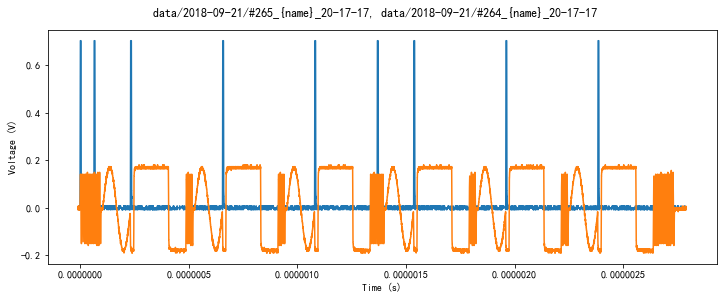

In [38]:
data_tr3 = send_and_read_back_wave(sample_count, rto, da, da_ctrl,trig_time)

#### 归一化显示发送波形与示波器采集的波形

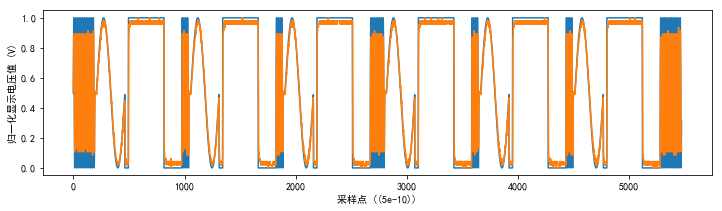

In [39]:
process_waves(wave, data_tr3.arrays['trace'])

### 三层嵌套  

触发时刻:0.0ns
触发时刻:64.0ns
触发时刻:248.0ns
触发时刻:672.0ns
触发时刻:1128.0ns
触发时刻:1552.0ns
触发时刻:2008.0ns
触发时刻:2432.0ns
触发时刻:2736.0ns
触发时刻:2920.0ns
触发时刻:3344.0ns
触发时刻:3800.0ns
触发时刻:4224.0ns
触发时刻:4680.0ns
触发时刻:5104.0ns
0层循环起始：地址：1
1层循环起始：地址：2
2层循环起始：地址：3
2层循环结束：跳转：3
1层循环结束：跳转：2
0层循环结束：跳转：1
[0, 1094, 2188, 3282, 4376, 5470, 6564, 7658, 8752, 9846, 10940, 10943]


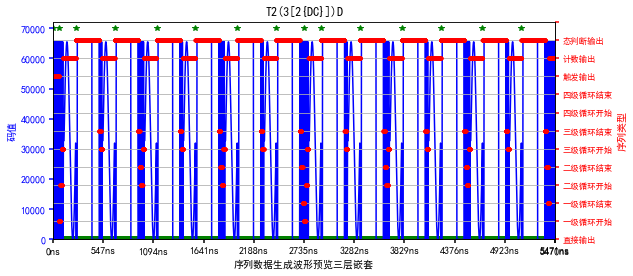

In [40]:
da_ctrl.seq = seq_T+seq_L1+seq_L2+seq_L3+seq_D+seq_C+seq_J3+seq_J2+seq_J1+\
seq_T_stop+[0,0,0,0]*10
sample_count,wave,trig_time = da_ctrl.wave_preview('三层嵌套')

#### 发送波形并读取示波器波形数据并画图

[0, 16, 0, 17453, 0, 4, 2, 3117, 0, 4, 3, 2304, 0, 4, 2, 2560, 16, 32, 2, 8192, 257, 64, 257, 25645, 0, 4, 3, 4608, 0, 4, 2, 4352, 0, 4, 1, 4096, 0, 16, 0, 40960, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
DataSet:
   location = 'data/2018-09-21/#266_{name}_20-17-18'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Measured | trace      | trace        | (55000,)
acquired at 2018-09-21 20:17:19
DataSet:
   location = 'data/2018-09-21/#267_{name}_20-17-19'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Measured | trace      | trace        | (55000,)
acquired at 2018-09-21 20:17:19
触发时刻匹配:0.0
触发时刻匹配:64.0
触发时刻匹配:248.0
触发时刻匹配:672.0
触发时刻匹配:1128.0
触发时刻匹配:1552.0
触发时刻匹配:2008.0
触发时刻匹配:2432.0
触发时刻匹配:2736.0
触发时刻匹配:2920.0
触发时刻匹配:3344.0
触发时刻匹配:3800.0
触发时刻匹配:4224.0
触发时刻不匹配：预期4680.0，实际4680.5
触发时刻匹配:5104.0


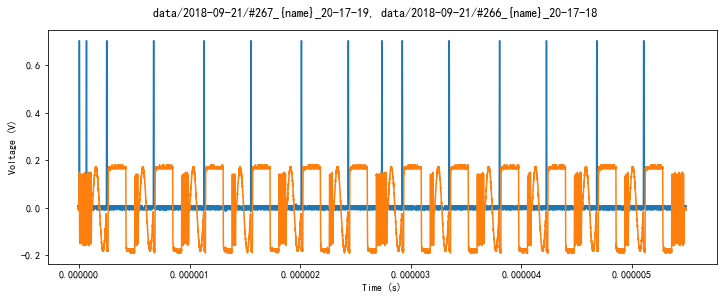

In [41]:
data_tr3 = send_and_read_back_wave(sample_count, rto, da, da_ctrl,trig_time)

#### 归一化显示发送波形与示波器采集的波形

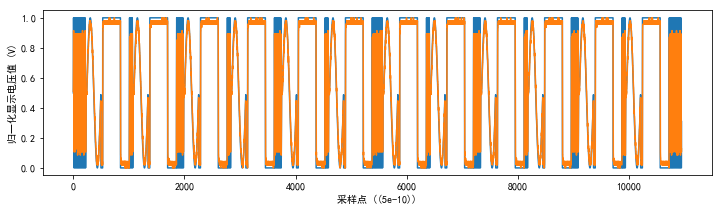

In [42]:
process_waves(wave, data_tr3.arrays['trace'])

### 四层嵌套  

触发时刻:0.0ns
触发时刻:64.0ns
触发时刻:264.0ns
触发时刻:688.0ns
触发时刻:1112.0ns
触发时刻:1568.0ns
触发时刻:1992.0ns
触发时刻:2416.0ns
触发时刻:2904.0ns
触发时刻:3328.0ns
触发时刻:3752.0ns
触发时刻:4208.0ns
触发时刻:4632.0ns
触发时刻:5056.0ns
触发时刻:5544.0ns
触发时刻:5968.0ns
触发时刻:6392.0ns
触发时刻:6848.0ns
触发时刻:7272.0ns
触发时刻:7696.0ns
触发时刻:8016.0ns
触发时刻:8216.0ns
触发时刻:8640.0ns
触发时刻:9064.0ns
触发时刻:9520.0ns
触发时刻:9944.0ns
触发时刻:10368.0ns
触发时刻:10856.0ns
触发时刻:11280.0ns
触发时刻:11704.0ns
触发时刻:12160.0ns
触发时刻:12584.0ns
触发时刻:13008.0ns
触发时刻:13496.0ns
触发时刻:13920.0ns
触发时刻:14344.0ns
触发时刻:14800.0ns
触发时刻:15224.0ns
触发时刻:15648.0ns
0层循环起始：地址：1
1层循环起始：地址：2
2层循环起始：地址：3
3层循环起始：地址：4
3层循环结束：跳转：4
2层循环结束：跳转：3
1层循环结束：跳转：2
0层循环结束：跳转：1
[0, 3206, 6412, 9618, 12824, 16030, 19236, 22442, 25648, 28854, 32060, 32063]


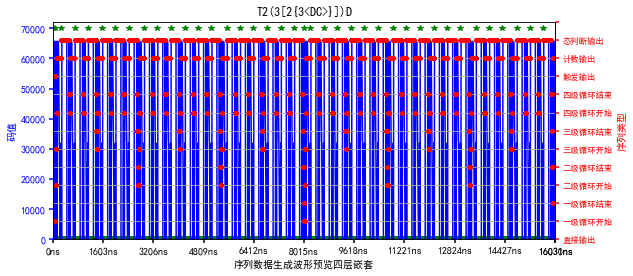

In [43]:
# %matplotlib notebook
da_ctrl.seq = seq_T+seq_L1+seq_L2+seq_L3+seq_L4+seq_D+seq_C+seq_J4+seq_J3+\
seq_J2+seq_J1+seq_T_stop+[0,0,0,0]*10
sample_count,wave,trig_time = da_ctrl.wave_preview('四层嵌套')

#### 发送波形并读取示波器波形数据并画图

[0, 16, 0, 17453, 0, 4, 2, 3117, 0, 4, 3, 2304, 0, 4, 2, 2560, 0, 4, 3, 2816, 16, 32, 2, 8192, 257, 64, 257, 25645, 0, 4, 4, 4864, 0, 4, 3, 4608, 0, 4, 2, 4352, 0, 4, 1, 4096, 0, 16, 0, 40960, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
DataSet:
   location = 'data/2018-09-21/#268_{name}_20-17-21'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Measured | trace      | trace        | (161000,)
acquired at 2018-09-21 20:17:22
DataSet:
   location = 'data/2018-09-21/#269_{name}_20-17-22'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Measured | trace      | trace        | (161000,)
acquired at 2018-09-21 20:17:24
触发时刻匹配:0.0
触发时刻匹配:64.0
触发时刻匹配:264.0
触发时刻匹配:688.0
触发时刻匹配:1112.0
触发时刻匹配:1568.0
触发时刻匹配:1992.0
触发时刻匹配:2416.0
触发时刻匹配:2904.0
触发时刻匹配:3328.0
触发时刻匹配:3752.0
触发时刻匹配:4208.0
触发时刻匹配:4632.0
触发时刻匹配:5056.0
触发时刻匹配:5544.0
触发时刻匹配:5968.0
触发时刻匹配:6392.0
触发时刻匹配:6848.0
触发时刻匹配:7272.0
触发时刻匹配:7696.0
触发时刻匹配:801

<IPython.core.display.Javascript object>


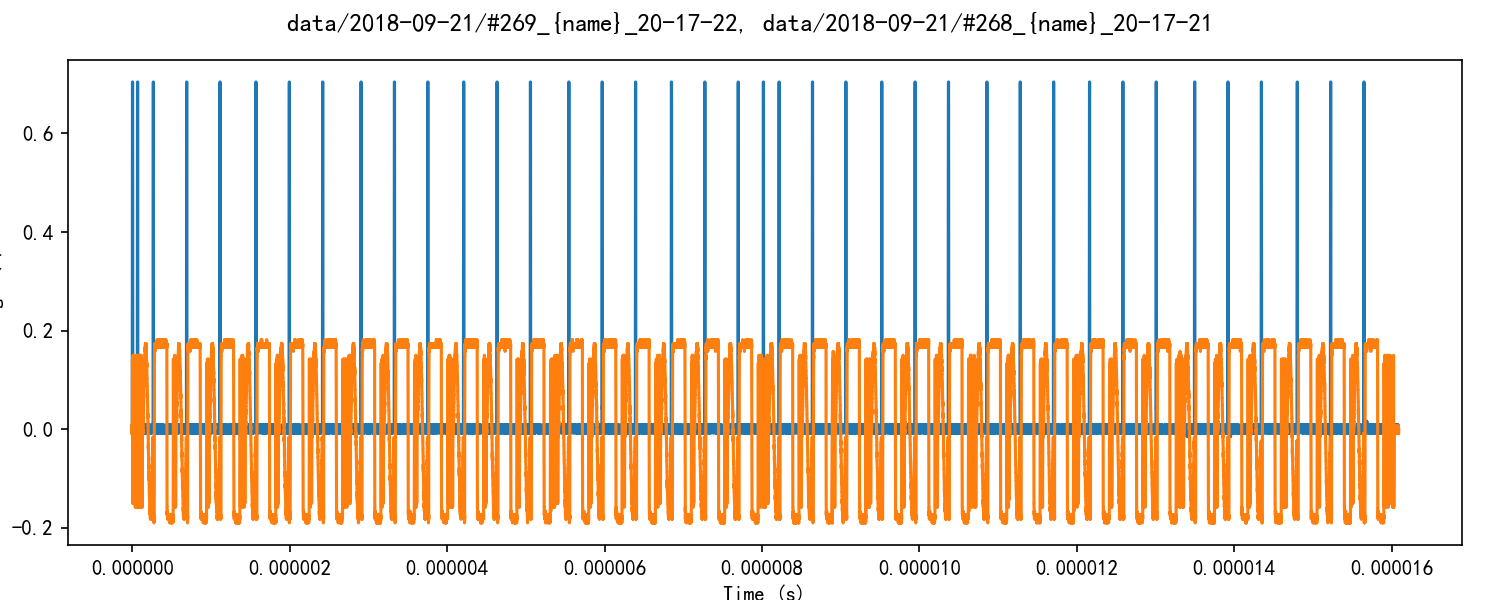

In [44]:
%matplotlib notebook
data_tr3 = send_and_read_back_wave(sample_count, rto, da, da_ctrl,trig_time)

#### 归一化显示发送波形与示波器采集的波形

<IPython.core.display.Javascript object>


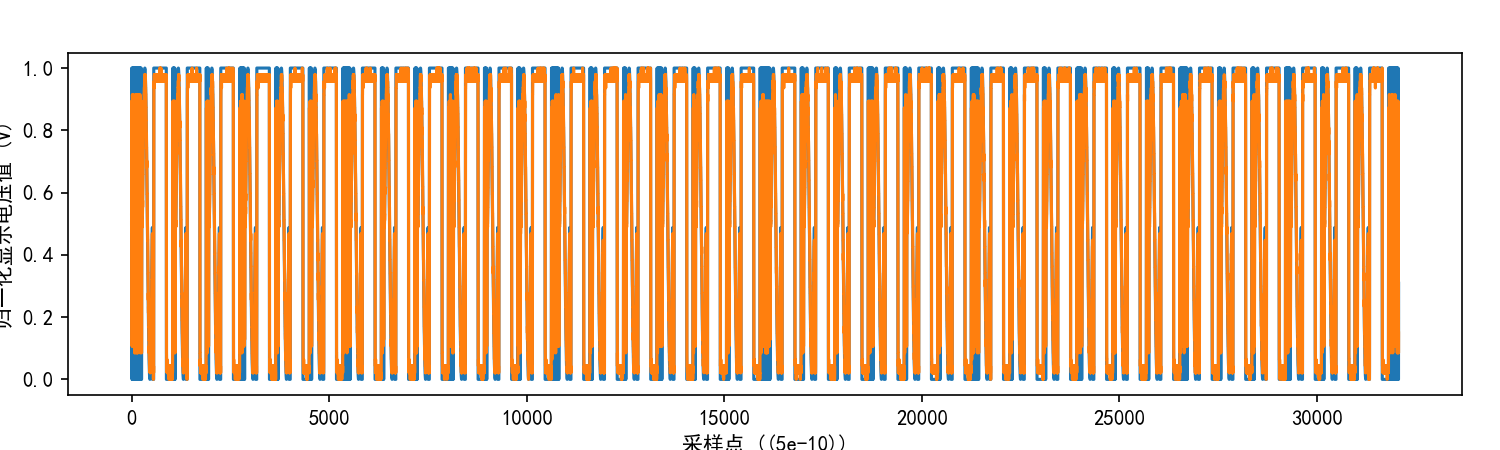

In [45]:
process_waves(wave, data_tr3.arrays['trace'])

### 三层嵌套2&3  

触发时刻:0.0ns
触发时刻:64.0ns
触发时刻:248.0ns
触发时刻:672.0ns
触发时刻:1128.0ns
触发时刻:1552.0ns
触发时刻:2008.0ns
触发时刻:2432.0ns
触发时刻:3648.0ns
触发时刻:3832.0ns
触发时刻:4256.0ns
触发时刻:4712.0ns
触发时刻:5136.0ns
触发时刻:5592.0ns
触发时刻:6016.0ns
0层循环起始：地址：1
1层循环起始：地址：2
2层循环起始：地址：3
2层循环结束：跳转：3
1层循环结束：跳转：2
3层循环起始：地址：8
3层循环结束：跳转：8
0层循环结束：跳转：1


<IPython.core.display.Javascript object>


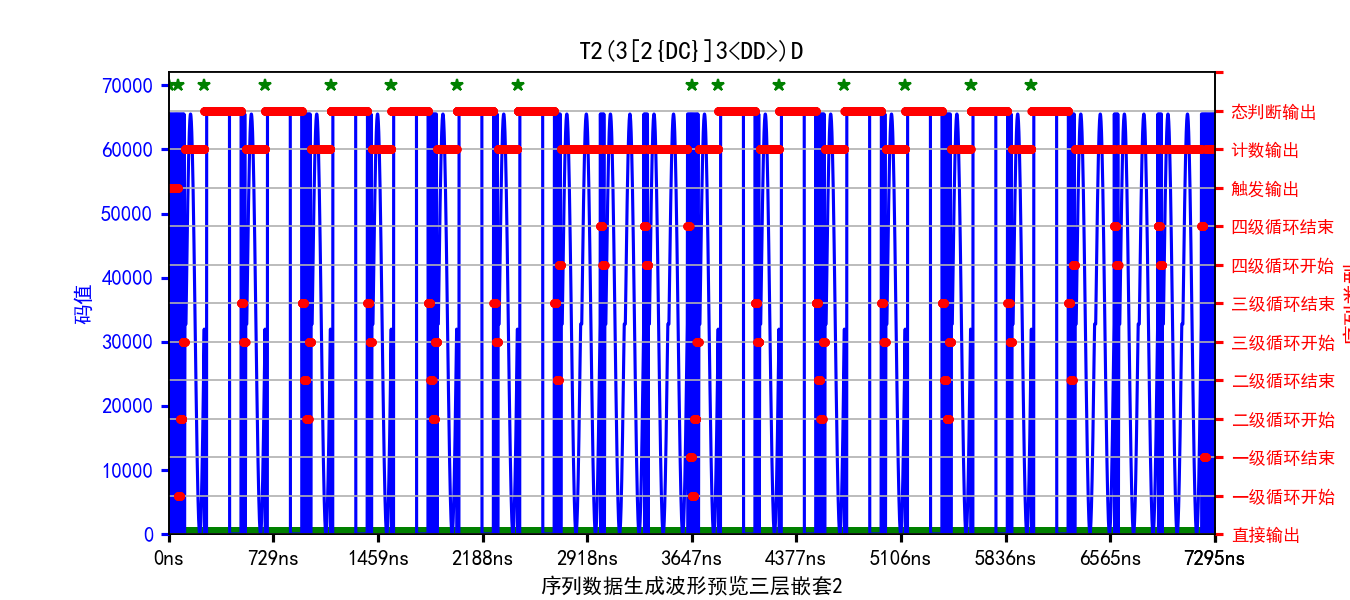

[0, 1459, 2918, 4377, 5836, 7295, 8754, 10213, 11672, 13131, 14590, 14591]


In [46]:
da_ctrl.seq = seq_T+seq_L1+seq_L2+seq_L3+seq_D+seq_C+seq_J3+seq_J2+seq_L4+\
seq_D*2+seq_J4+seq_J1+seq_T_stop+[0,0,0,0]*10 
sample_count,wave,trig_time = da_ctrl.wave_preview('三层嵌套2')

#### 发送波形并读取示波器波形数据并画图

[0, 16, 0, 17453, 0, 4, 2, 3117, 0, 4, 3, 2304, 0, 4, 2, 2560, 16, 32, 2, 8192, 257, 64, 257, 25645, 0, 4, 3, 4608, 0, 4, 2, 4352, 0, 4, 3, 2816, 16, 32, 2, 8192, 16, 32, 2, 8192, 0, 4, 8, 4864, 0, 4, 1, 4096, 0, 16, 0, 40960, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
DataSet:
   location = 'data/2018-09-21/#270_{name}_20-17-24'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Measured | trace      | trace        | (73000,)
acquired at 2018-09-21 20:17:25
DataSet:
   location = 'data/2018-09-21/#271_{name}_20-17-25'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Measured | trace      | trace        | (73000,)
acquired at 2018-09-21 20:17:26
触发时刻匹配:0.0
触发时刻匹配:64.0
触发时刻匹配:248.0
触发时刻匹配:672.0
触发时刻匹配:1128.0
触发时刻匹配:1552.0
触发时刻匹配:2008.0
触发时刻匹配:2432.0
触发时刻匹配:3648.0
触发时刻匹配:3832.0
触发时刻匹配:4256.0
触发时刻匹配:4712.0
触发时刻匹配:5136.0
触发时刻匹配:5592.0
触发时刻匹配:6016.0


<IPython.core.display.Javascript object>


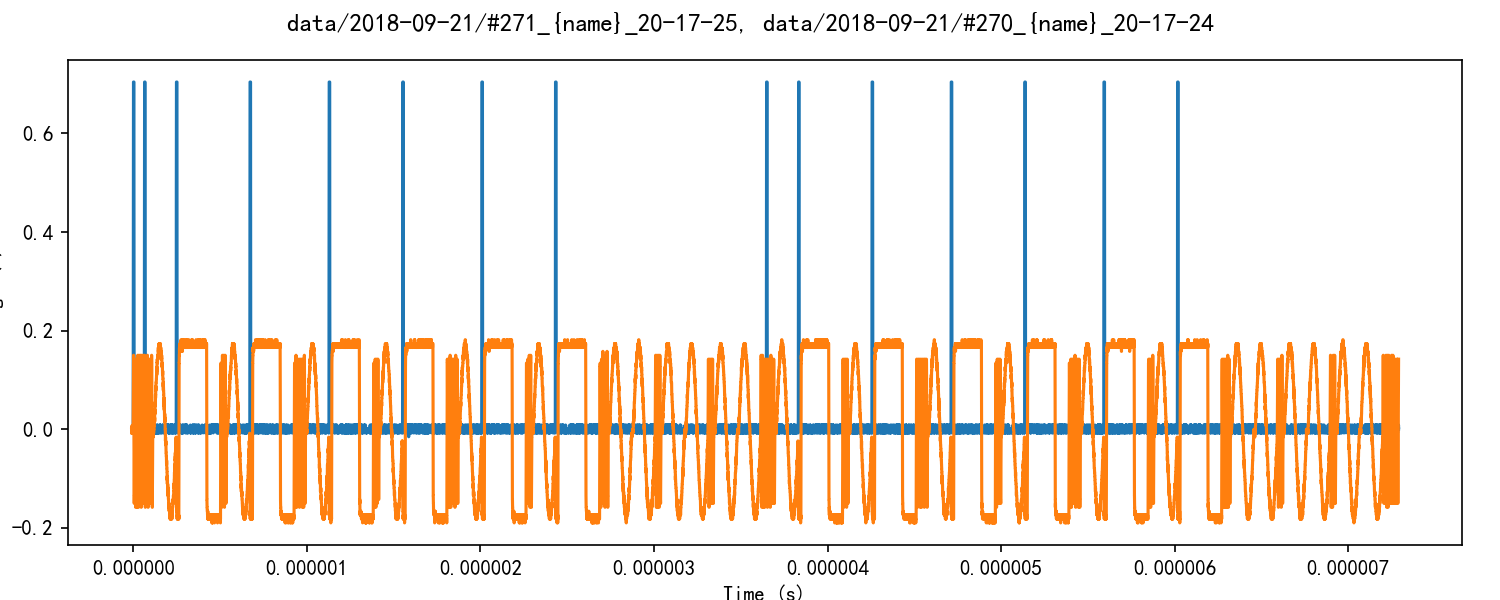

In [47]:
data_tr3 = send_and_read_back_wave(sample_count, rto, da, da_ctrl,trig_time)

#### 归一化显示发送波形与示波器采集的波形

<IPython.core.display.Javascript object>


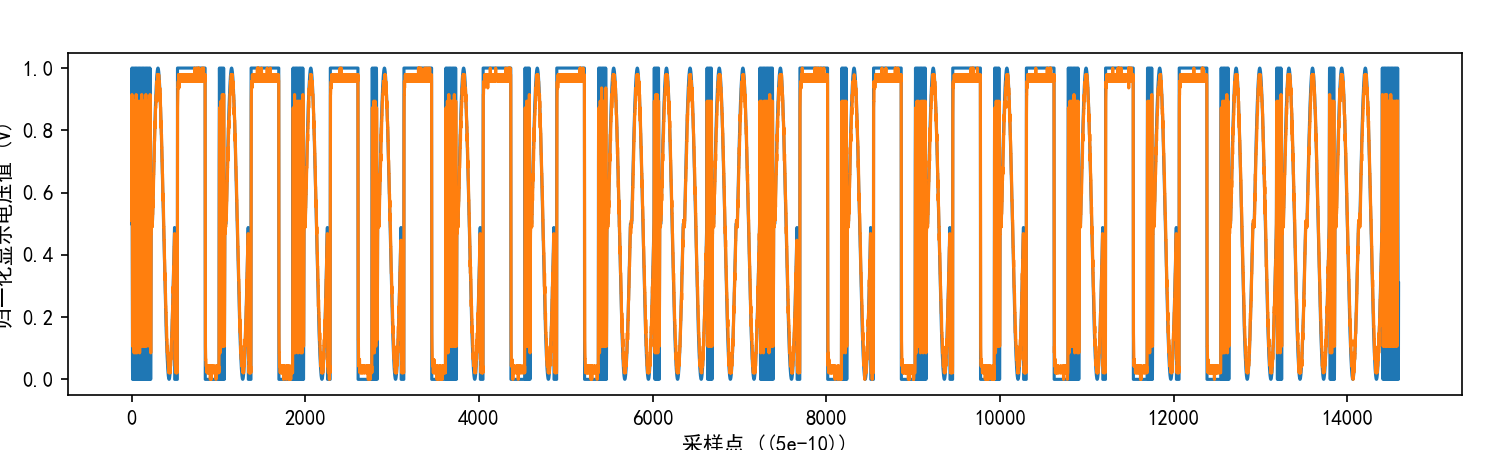

In [48]:
process_waves(wave, data_tr3.arrays['trace'])

触发时刻:0.0ns
触发时刻:64.0ns
触发时刻:248.0ns
触发时刻:672.0ns
触发时刻:1128.0ns
触发时刻:1552.0ns
触发时刻:2008.0ns
触发时刻:2432.0ns
触发时刻:3648.0ns
触发时刻:3832.0ns
触发时刻:4256.0ns
触发时刻:4712.0ns
触发时刻:5136.0ns
触发时刻:5592.0ns
触发时刻:6016.0ns
0层循环起始：地址：1
1层循环起始：地址：2
2层循环起始：地址：3
2层循环结束：跳转：3
1层循环结束：跳转：2
1层循环起始：地址：8
1层循环结束：跳转：8
0层循环结束：跳转：1


<IPython.core.display.Javascript object>


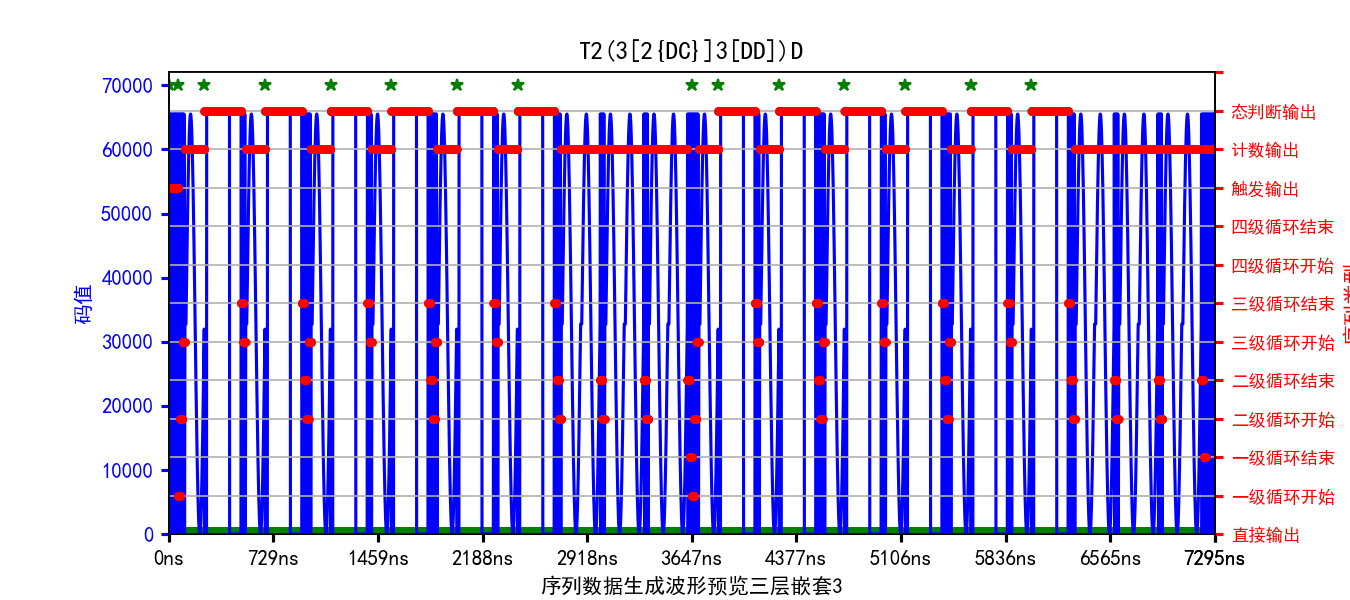

[0, 1459, 2918, 4377, 5836, 7295, 8754, 10213, 11672, 13131, 14590, 14591]


In [49]:
da_ctrl.seq = seq_T+seq_L1+seq_L2+seq_L3+seq_D+seq_C+seq_J3+seq_J2+seq_L2+\
seq_D*2+seq_J2+seq_J1+seq_T_stop+[0,0,0,0]*4
sample_count,wave,trig_time = da_ctrl.wave_preview('三层嵌套3')

#### 发送波形并读取示波器波形数据并画图

[0, 16, 0, 17453, 0, 4, 2, 3117, 0, 4, 3, 2304, 0, 4, 2, 2560, 16, 32, 2, 8192, 257, 64, 257, 25645, 0, 4, 3, 4608, 0, 4, 2, 4352, 0, 4, 3, 2304, 16, 32, 2, 8192, 16, 32, 2, 8192, 0, 4, 8, 4352, 0, 4, 1, 4096, 0, 16, 0, 40960, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
DataSet:
   location = 'data/2018-09-21/#272_{name}_20-17-26'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Measured | trace      | trace        | (73000,)
acquired at 2018-09-21 20:17:27
DataSet:
   location = 'data/2018-09-21/#273_{name}_20-17-27'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Measured | trace      | trace        | (73000,)
acquired at 2018-09-21 20:17:27
触发时刻匹配:0.0
触发时刻匹配:64.0
触发时刻匹配:248.0
触发时刻匹配:672.0
触发时刻匹配:1128.0
触发时刻匹配:1552.0
触发时刻匹配:2008.0
触发时刻匹配:2432.0
触发时刻匹配:3648.0
触发时刻匹配:3832.0
触发时刻匹配:4256.0
触发时刻匹配:4712.0
触发时刻匹配:5136.0
触发时刻匹配:5592.0
触发时刻匹配:6016.0


<IPython.core.display.Javascript object>


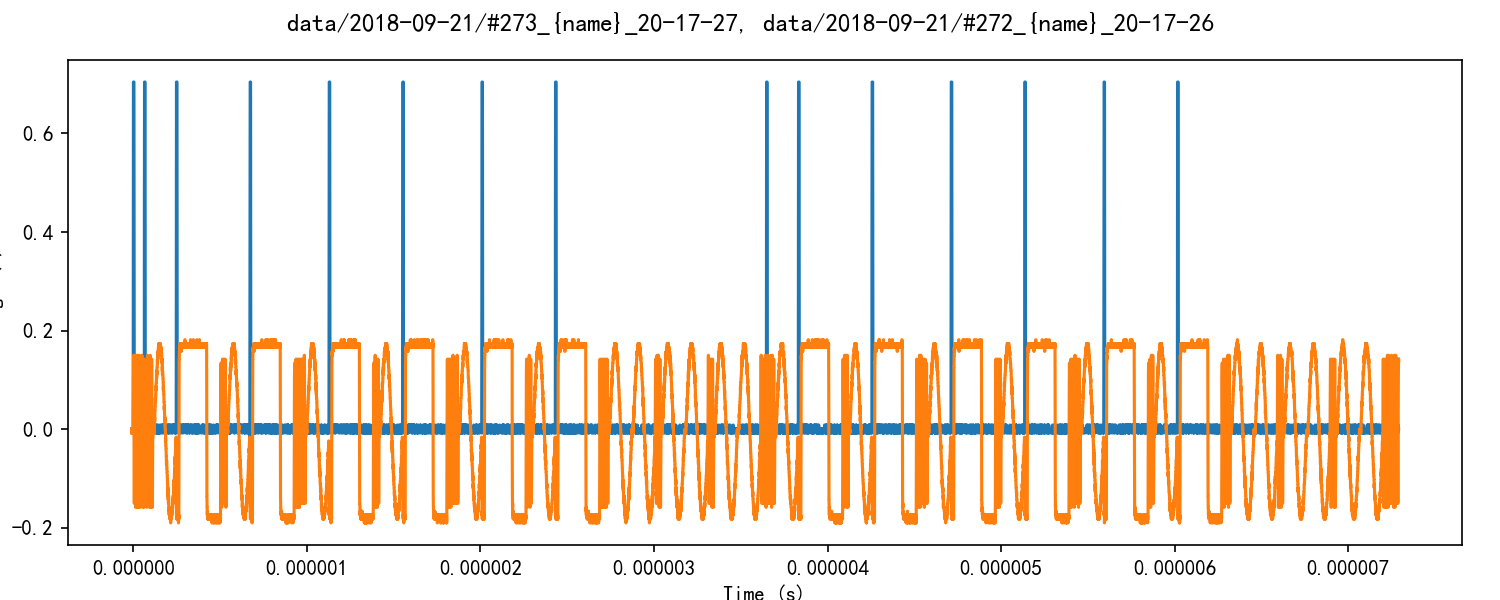

In [50]:
data_tr3 = send_and_read_back_wave(sample_count, rto, da, da_ctrl,trig_time)

#### 归一化显示发送波形与示波器采集的波形

<IPython.core.display.Javascript object>


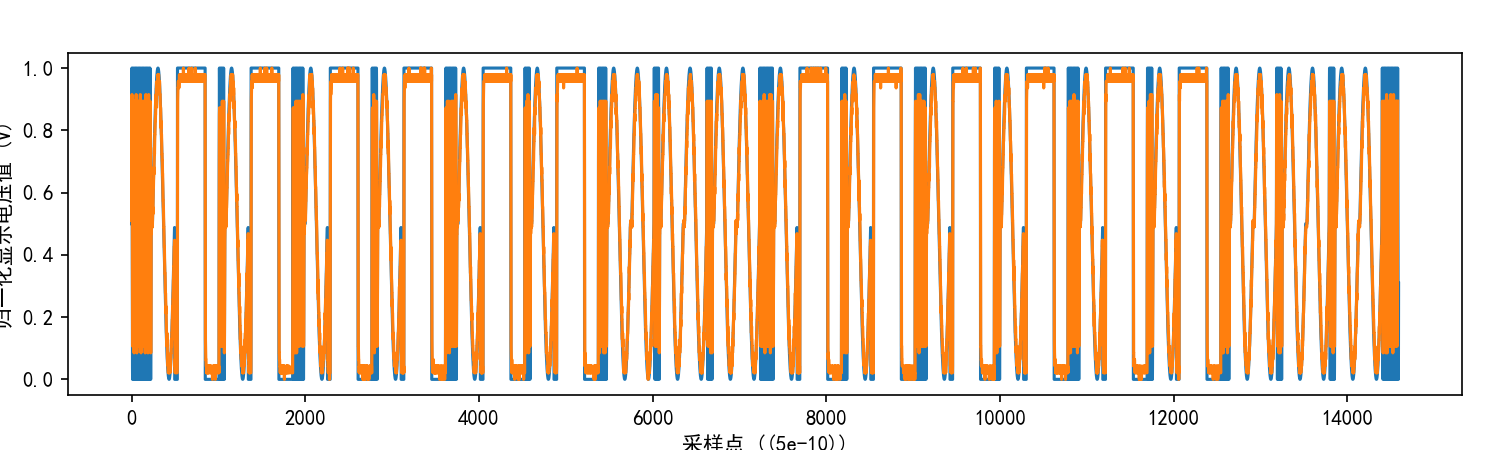

In [51]:
process_waves(wave, data_tr3.arrays['trace'])

## 定义多次平均的方式进行测试

In [52]:
def send_and_read_back_wave1(sample_count, rto, da, da_ctrl):
    duration = (int(sample_count+40) >> 1) * 10e-10
    duration = int((sample_count+199)/200) * 10e-8
    rto.timebase_range(duration) 
    rto.timebase_position(duration/2 - 10e-9)
    repeat_cnt = 1000
    rto.high_definition_state('ON')  # 'ON' -> 16 bit, 'OFF' -> 8 bit
    rto.num_acquisitions(repeat_cnt)
#     rto.ch3.arithmetics('AVERAGE')  # other options: 'ENVELOPE' and 'OFF'
#     rto.ch1.arithmetics('AVERAGE')  # other options: 'ENVELOPE' and 'OFF'
#     rto.run_cont()
#     rto.run_single()  # and perform a single run. 
    for i in range(1,5):
        da.WriteSeq(i,da_ctrl.seq)
    
    da.StartStop(240)
    da.StartStop(15)
    da.SetTrigCount(1)
    da.SetLoop(repeat_cnt, repeat_cnt, repeat_cnt, repeat_cnt)
    for i in range(repeat_cnt):
        da.SendIntTrig()
        time.sleep(0.01)

    #读取示波器波形数据并画图

    # Next, the trace must be prepared. This ensures that all settings are correct
    rto.ch3.trace.prepare_trace()
    rto.ch1.trace.prepare_trace()
    # Now make a measurement of the trace and display it
    data_tr3 = qc.Measure(rto.ch3.trace).run()
    data_tr1 = qc.Measure(rto.ch1.trace).run()

    plot = qc.MatPlot(subplots=1, figsize=(10,3))
    plot[0].add(data_tr1.arrays['trace'])
    plot[0].add(data_tr3.arrays['trace'])
    return data_tr3

### 无嵌套

触发时刻:0.0ns


<IPython.core.display.Javascript object>


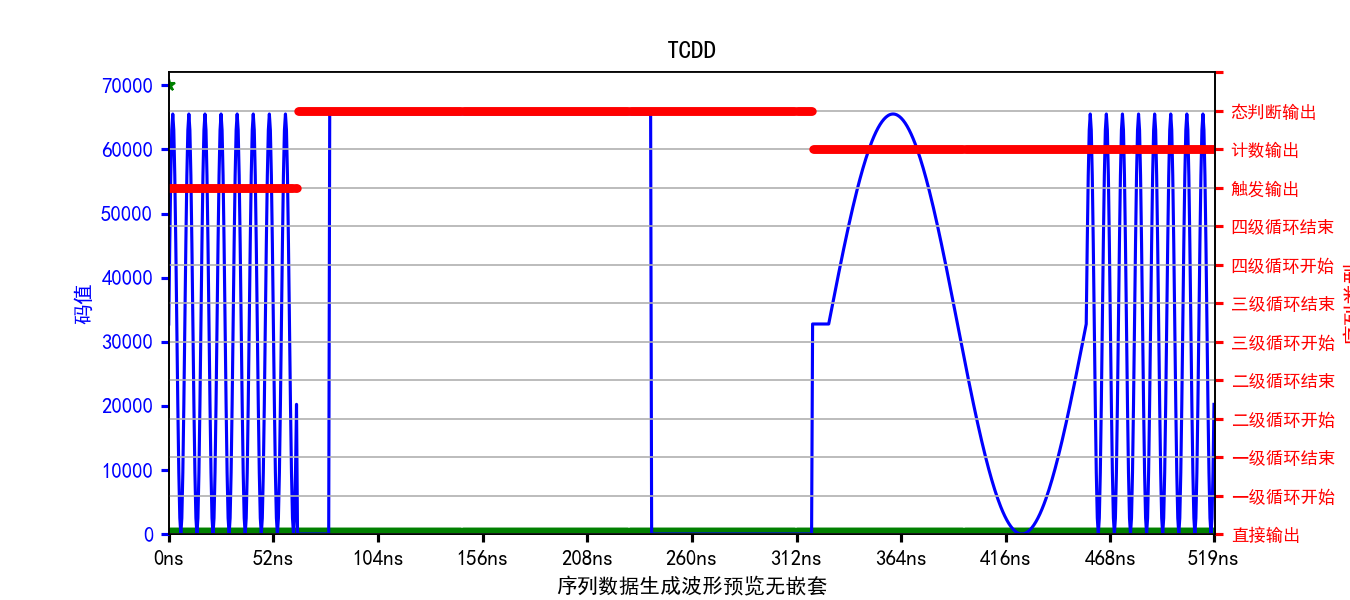

[0, 104, 208, 312, 416, 520, 624, 728, 832, 936, 1039]


In [53]:
seq_C[3] = seq_C[3] & 0xF800
da_ctrl.seq = seq_T+seq_C+seq_D+seq_T_stop+[0,0,0,0]*10
sample_count,wave,trig_time = da_ctrl.wave_preview('无嵌套')

[0, 16, 0, 17453, 257, 64, 257, 24576, 16, 32, 2, 8192, 0, 16, 0, 40960, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
DataSet:
   location = 'data/2018-09-21/#274_{name}_20-17-29'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Measured | trace      | trace        | (6000,)
acquired at 2018-09-21 20:17:29
DataSet:
   location = 'data/2018-09-21/#275_{name}_20-17-29'
   <Type>   | <array_id> | <array.name> | <array.shape>
   Measured | trace      | trace        | (6000,)
acquired at 2018-09-21 20:17:29
触发时刻匹配:0.0


<IPython.core.display.Javascript object>


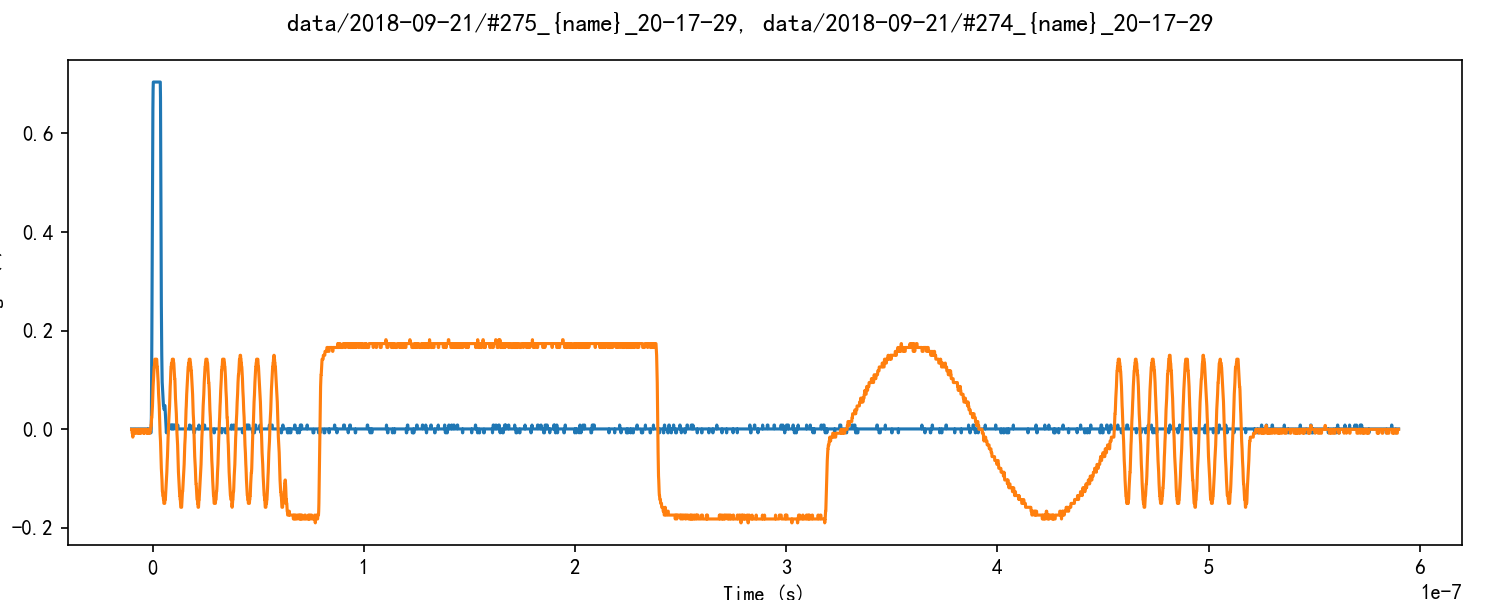

In [54]:
time.sleep(1)
data_tr3_1 = send_and_read_back_wave(sample_count, rto, da, da_ctrl,trig_time)

<IPython.core.display.Javascript object>


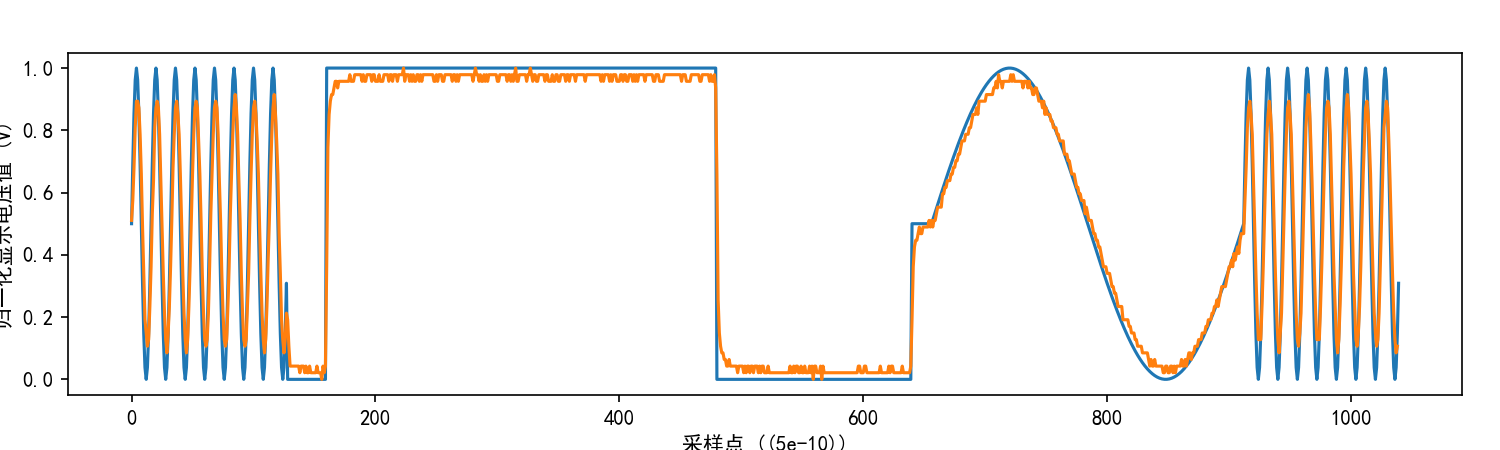

In [55]:

process_waves(wave, data_tr3_1.arrays['trace'])

In [56]:
# da.disconnect()